# Dense Retrieval

1. In the first part, we'll connect to the same database that we used in Lesson 1, but instead of doing keyword search, we will do **vector search using the embeddings to do semantic search**. 
2. Then, in the second part, having been comfortable with querying a vector database that's already been prepared for us, we will process the text from the beginning and see **how we can build from scratch a vector index**.


## Setup

Load needed API keys and relevant Python libaries.

In [ ]:
# !pip install cohere 
# !pip install weaviate-client Annoy

In [ ]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [ ]:
import cohere
co = cohere.Client(os.environ['COHERE_API_KEY'])

In [ ]:
import weaviate
auth_config = weaviate.auth.AuthApiKey(
    api_key=os.environ['WEAVIATE_API_KEY'])

In [ ]:
client = weaviate.Client(
    url=os.environ['WEAVIATE_API_URL'],
    auth_client_secret=auth_config,
    additional_headers={
        "X-Cohere-Api-Key": os.environ['COHERE_API_KEY'],
    }
)
client.is_ready() #check if True

Now, before we get to the code for searching by embeddings for dense retrieval, let's see what it means based on what we learned in the embeddings lesson.  

So, we have the query, what is the capital of Canada, and we have let's say five possible responses or sentences in our archive. 

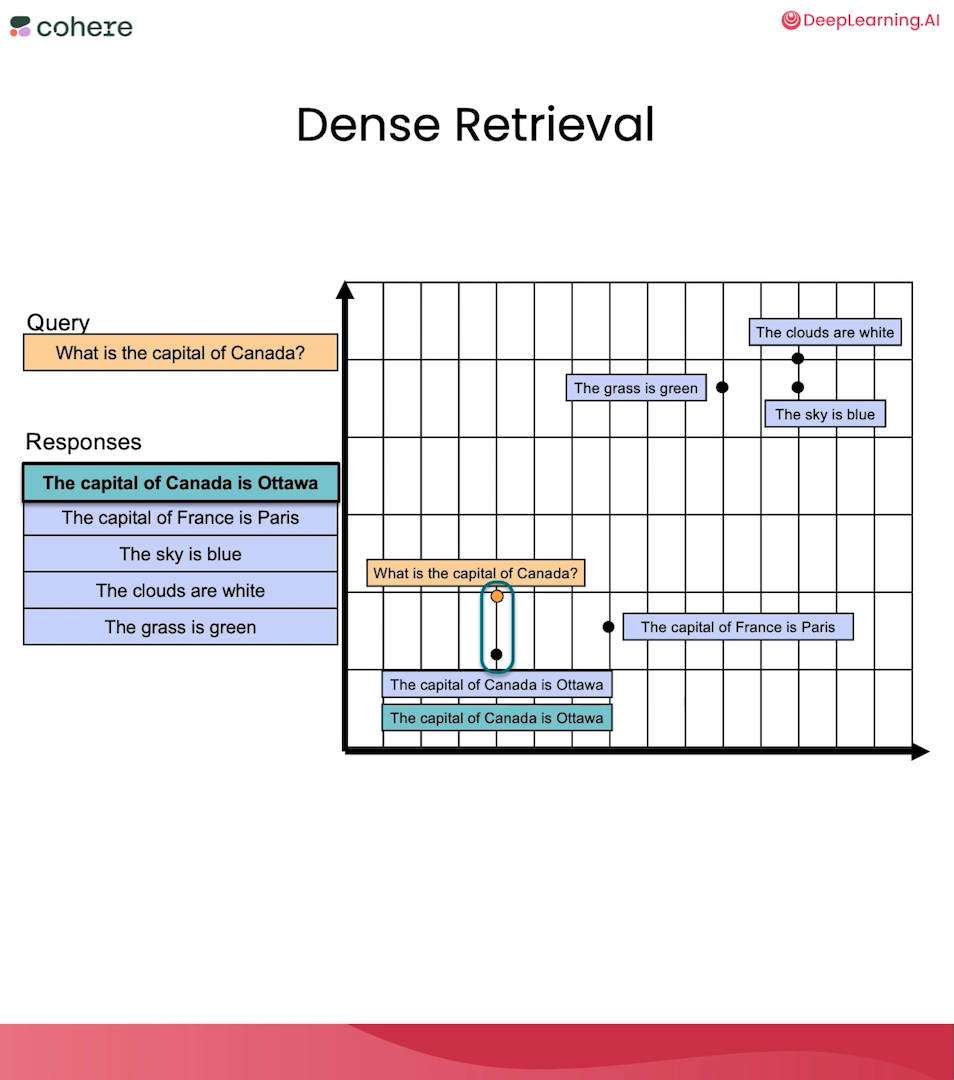

The capital of Canada is Ottawa, the capital of France is Paris. We can plot these just like we did with the embeddings, and we can see that sentences that are similar in meaning will be close to each other in the plot. So, if we plot all of these five, we can see that the sentences about the capitals of Canada and France are close to each other, and then the sentences about the colors are close to each other at the top right there. 

Now, where would this query be if we project it into the same embedding space? If we use an embeddings model that is optimized for search, it will be closest to the answer of that query. And so, when we ask what is the capital of Canada, it will be closest to this point, this sentence that says the capital of Canada is Ottawa. And that is how we use what we learned in embeddings, these properties of similarity and distance into search. 

And that is **dense retrieval**, one of the two main ways of doing semantic search, the other one being re-rankers. 


## Part 1: Vector Database for semantic Search

In [ ]:
def dense_retrieval(query, 
                    results_lang='en', 
                    properties = ["text", "title", "url", "views", "lang", "_additional {distance}"],
                    num_results=5):

    nearText = {"concepts": [query]}
    
    # To filter by language
    where_filter = {
    "path": ["lang"],
    "operator": "Equal",
    "valueString": results_lang
    }
    response = (
        client.query
        .get("Articles", properties)
        .with_near_text(nearText)
        .with_where(where_filter)
        .with_limit(num_results)
        .do()
    )

    result = response['data']['Get']['Articles']

    return result

The main difference here is that instead of using BM25, we're saying with near text. Near text here, we pass the query to. So, we put the query in this Python dictionary, we call it nearText, and then, we throw that variable at the query, and then, that is how we get the response back. So, this is how Weaviate does vector search instead of PM25 keyword search. 

In [ ]:
from utils import print_result

### Bacic Query

In [ ]:
query = "Who wrote Hamlet?"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

*OUTPUT*
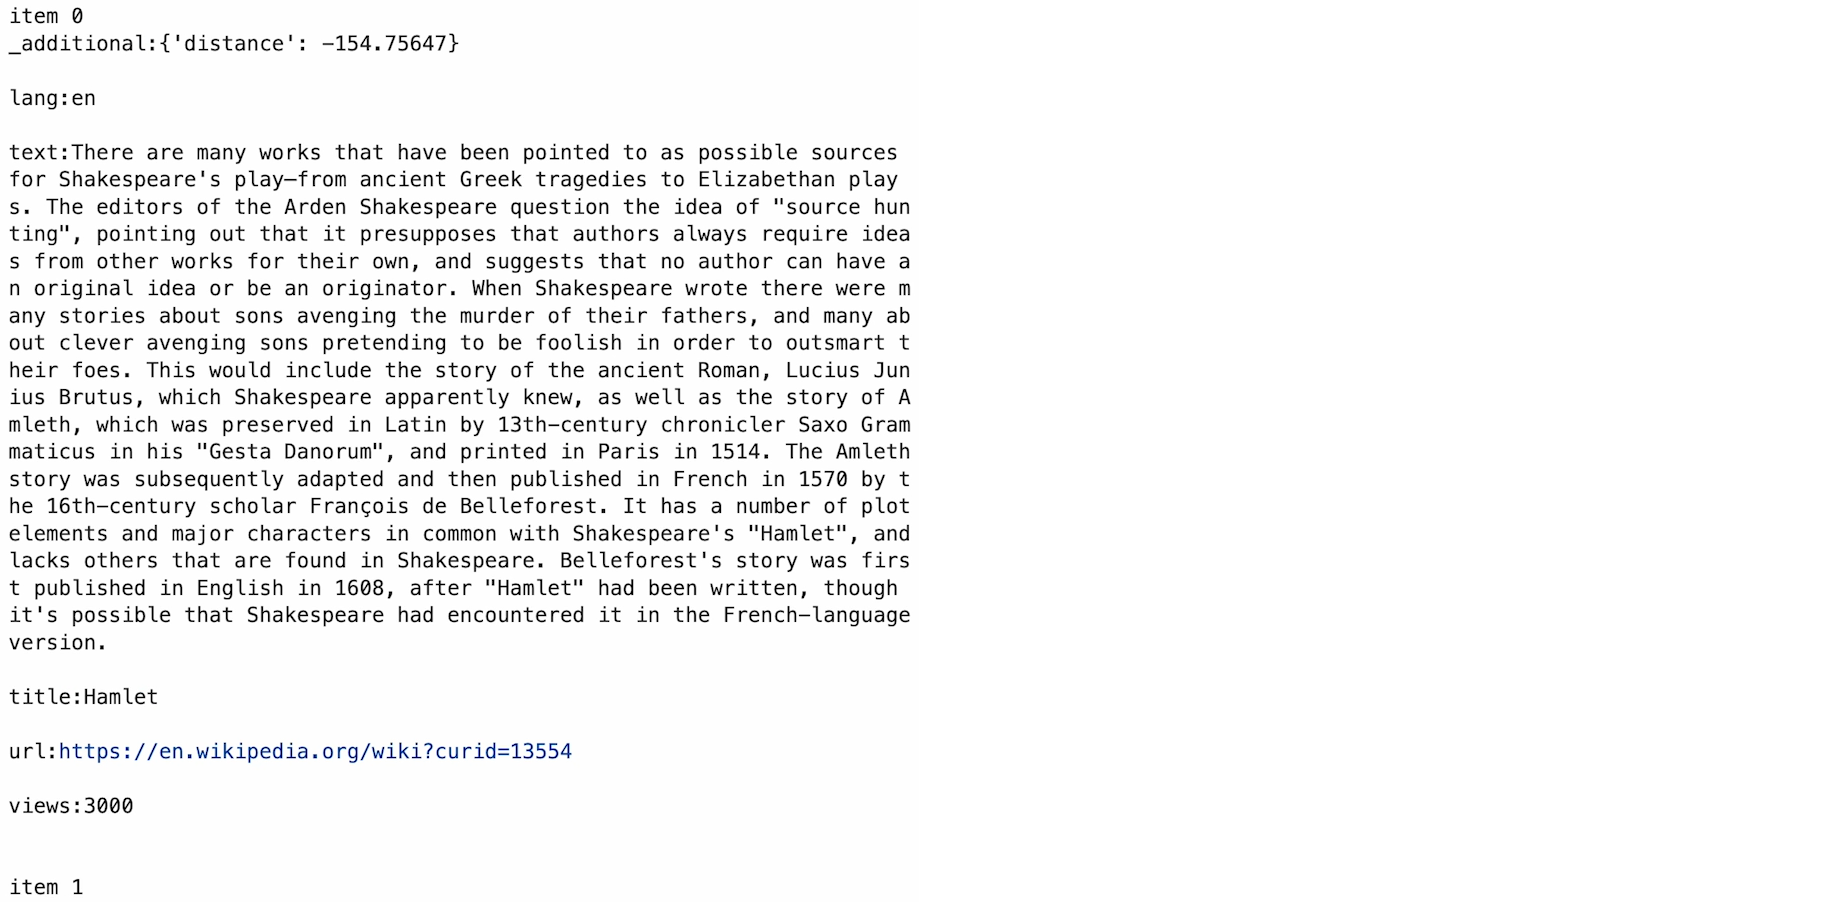

So, this is the first result. What happened here is that the embedding of all of this text was matched against the query. And this is the text that is most similar to this query. And in here, we can see that it talks about Shakespeare writing Hamlet. And so, this is the most relevant text in the archive for this query. We can see in the second result as well, it mentions Shakespeare and writing as well. So, that's another relevant result here. 

We've yet to return this `distance` number. This indicates how close the query is to the text here. Let us now try another query, which might be a little bit more difficult. So, let's say what is the capital of Canada and we search, and the first result is from. The page Wikipedia page for Ottawa, which is the capital for Canada. 

### Medium Query

In [ ]:
query = "What is the capital of Canada?"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

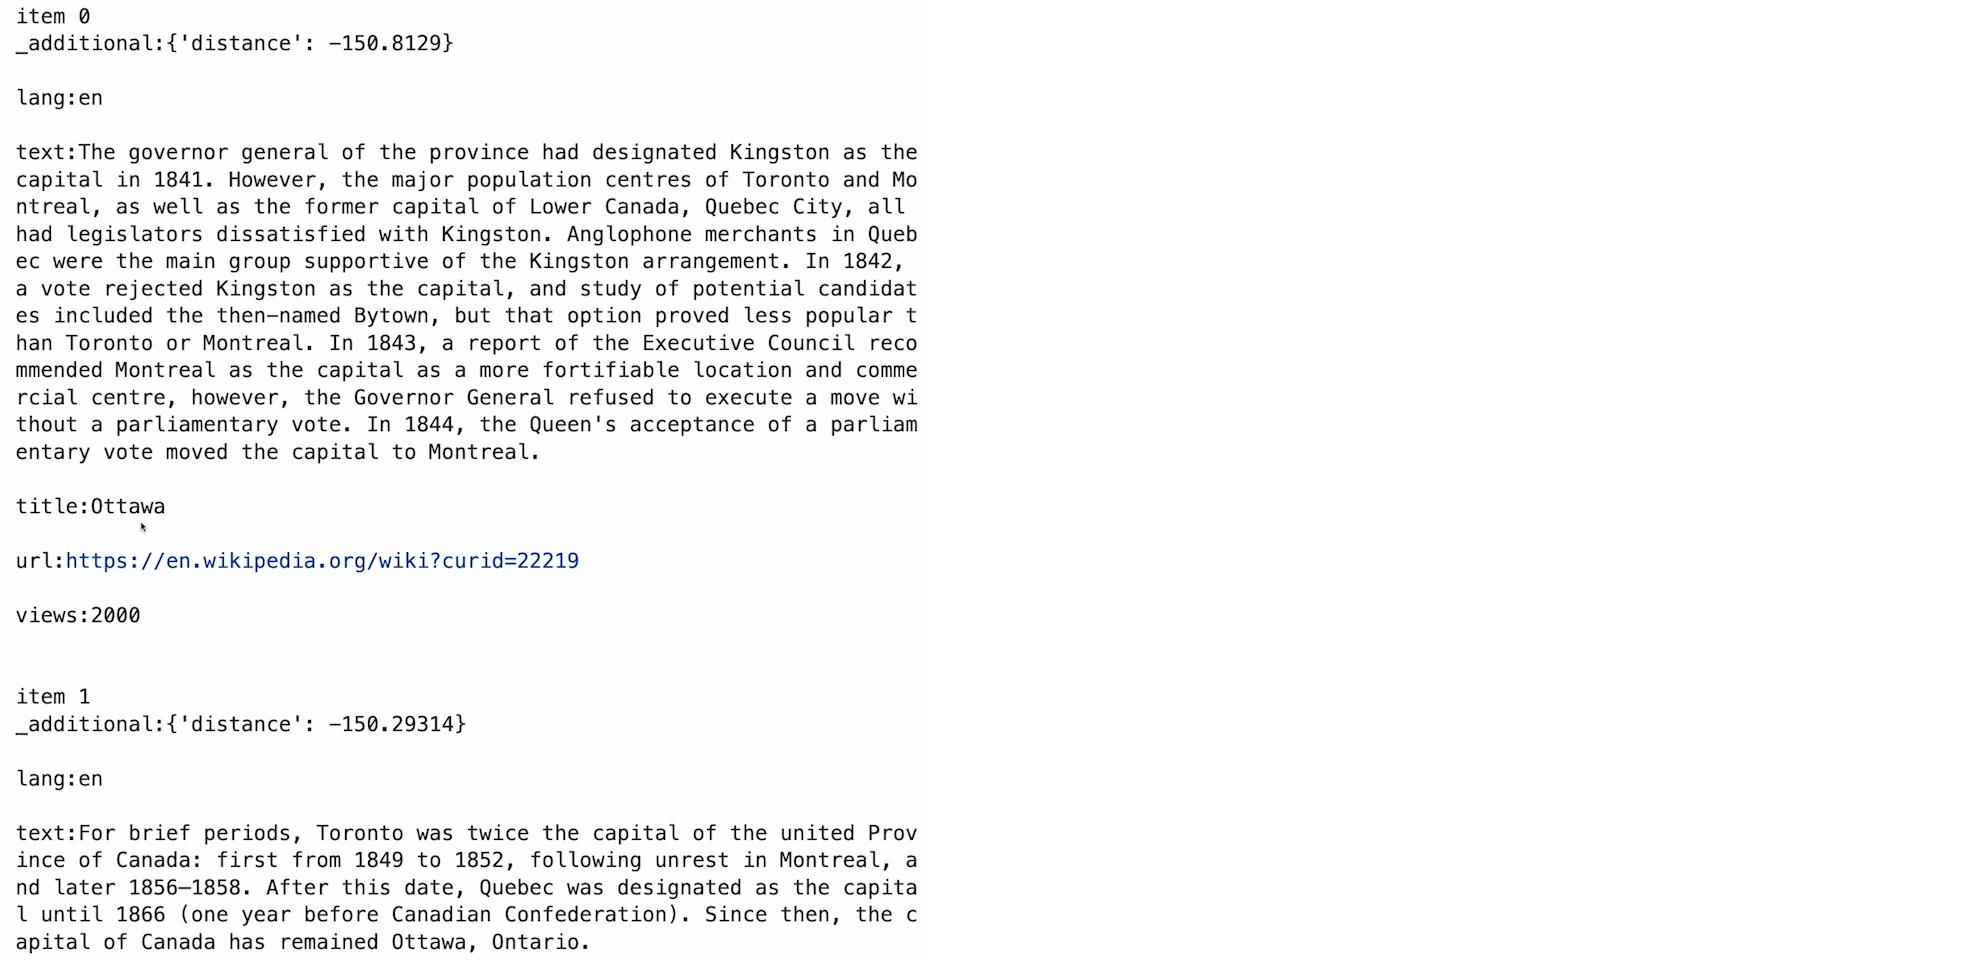

The page Wikipedia page for Ottawa, which is the capital for Canada. 

In [ ]:
from utils import keyword_search

query = "What is the capital of Canada?"
keyword_search_results = keyword_search(query, client)
print_result(keyword_search_results)

*OUTPUT*
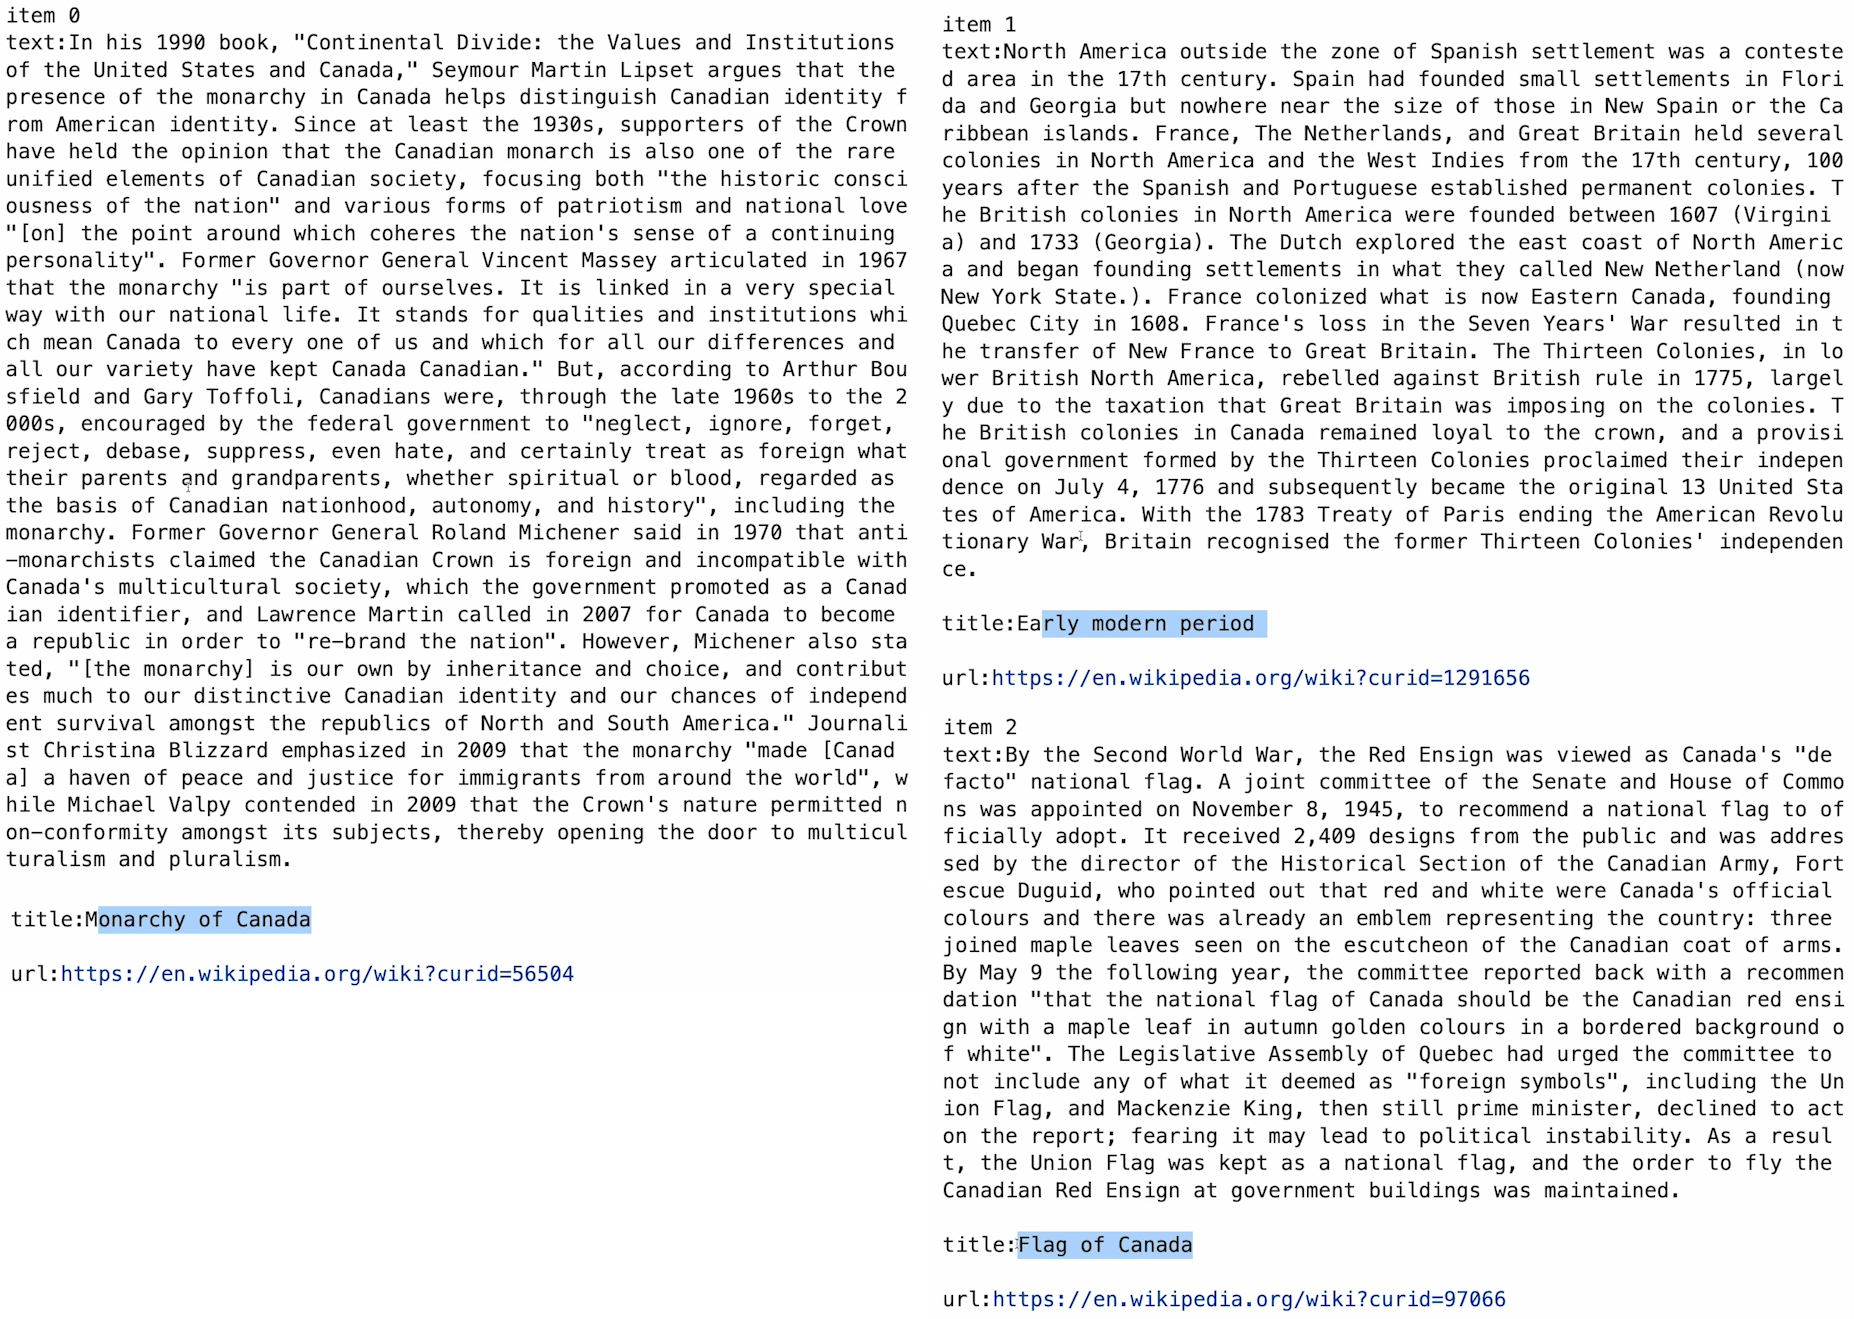

Let's import the keyword search function that we built in lesson 1 and pass the same query to that function, and let's see what the results are. The first result returned is about the monarchy of Canada, so kind of relevant but not really the capital of Canada. The second page is about the early modern period, and the third result is about the flag of Canada, so kind of in the same space, all talking about Canada, maybe not this one as much, but not really the answer to the query that we want, and not really the most relevant passages from the dataset to this query. 

### Complicated Query

In [ ]:
from utils import keyword_search

query = "Tallest person in history?"
keyword_search_results = keyword_search(query, client)
print_result(keyword_search_results)

*OUTPUT*
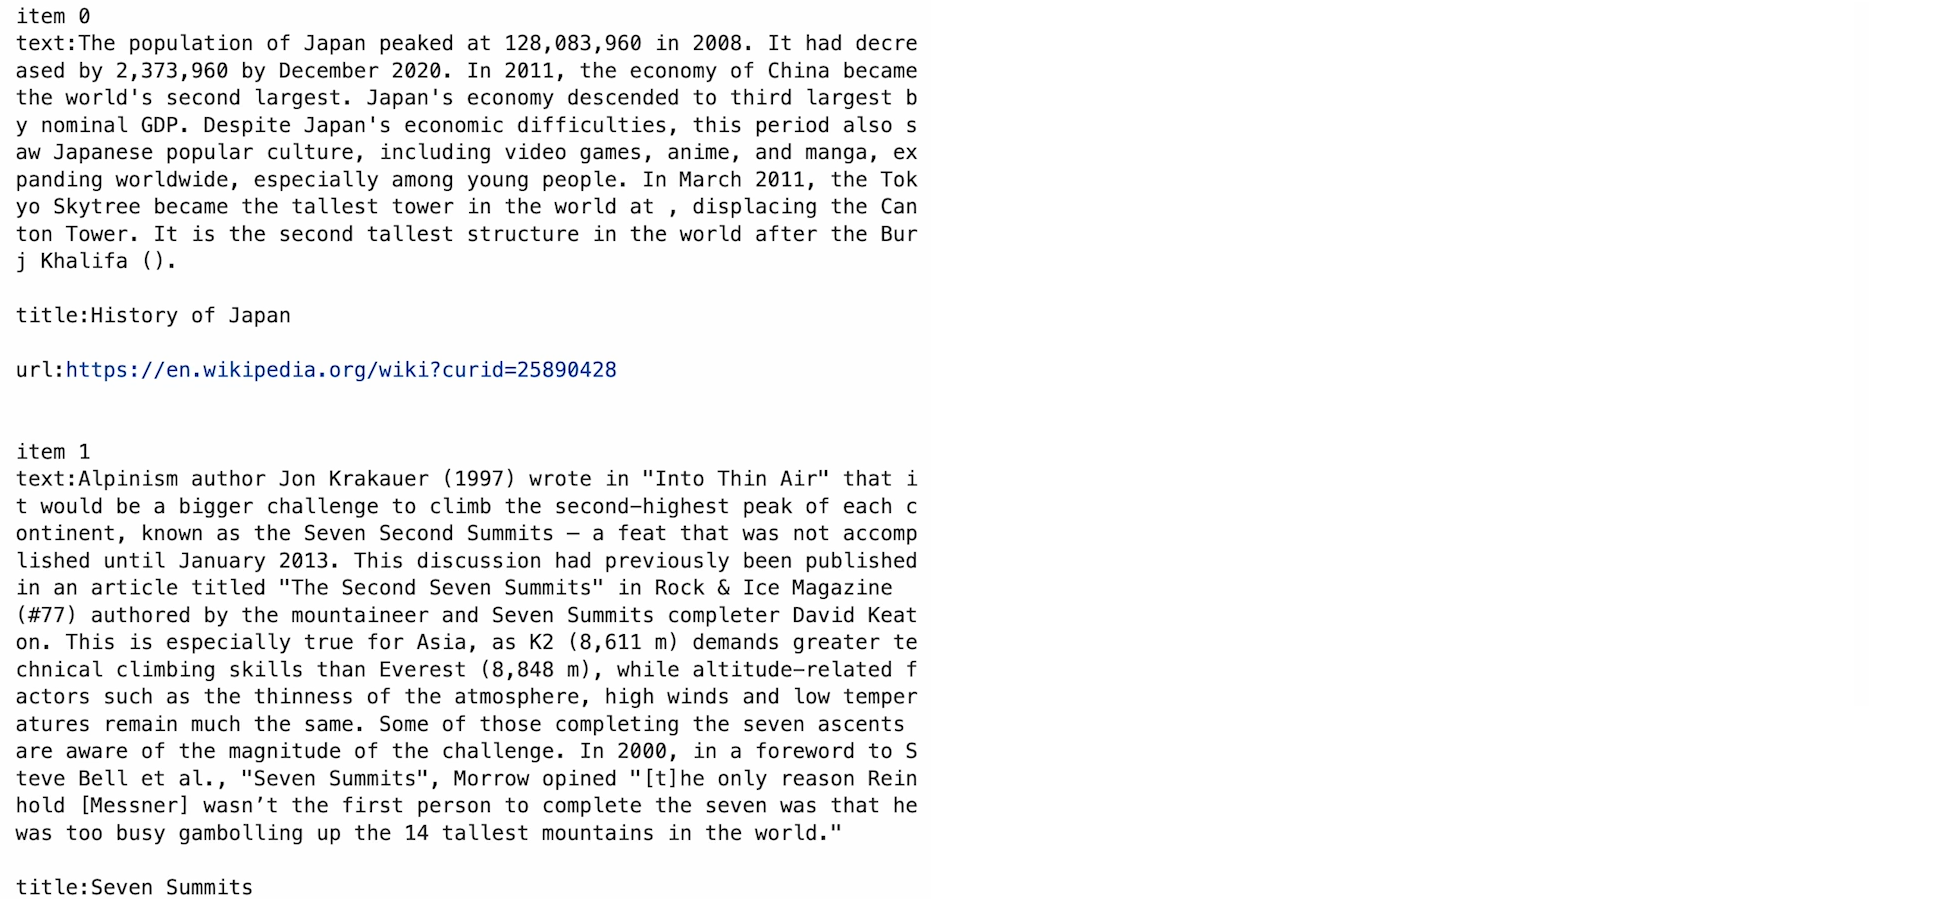

In [ ]:
# Now with dense_retrieval

query = "Tallest person in history"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

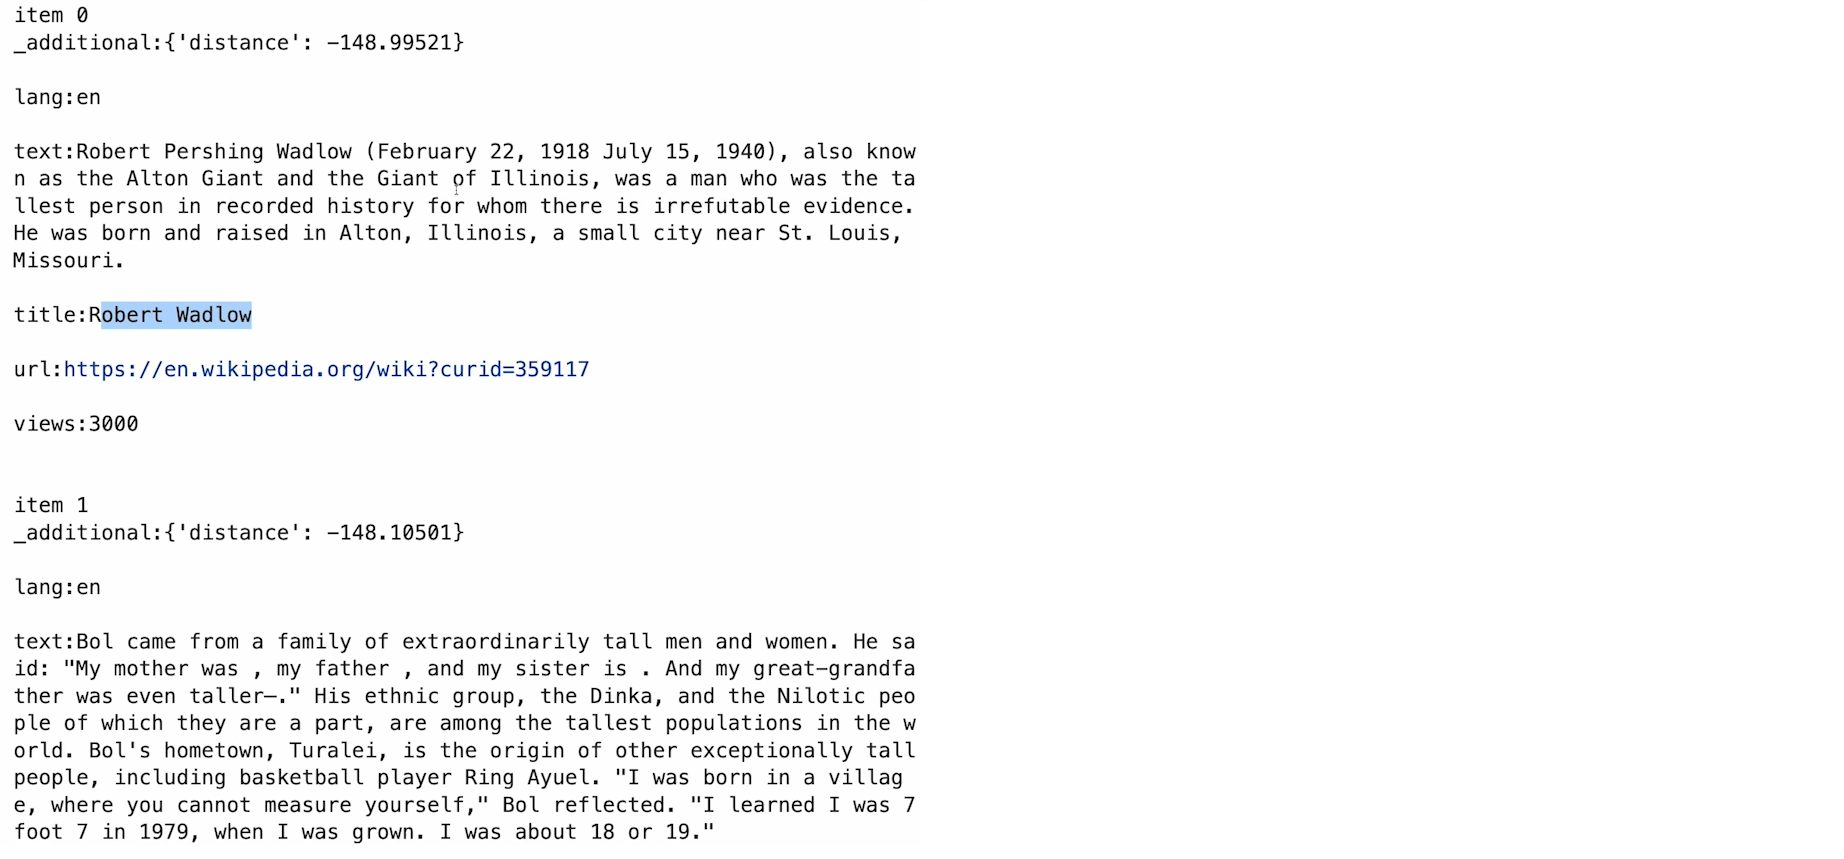

In [ ]:
query = "أطول رجل في التاريخ"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

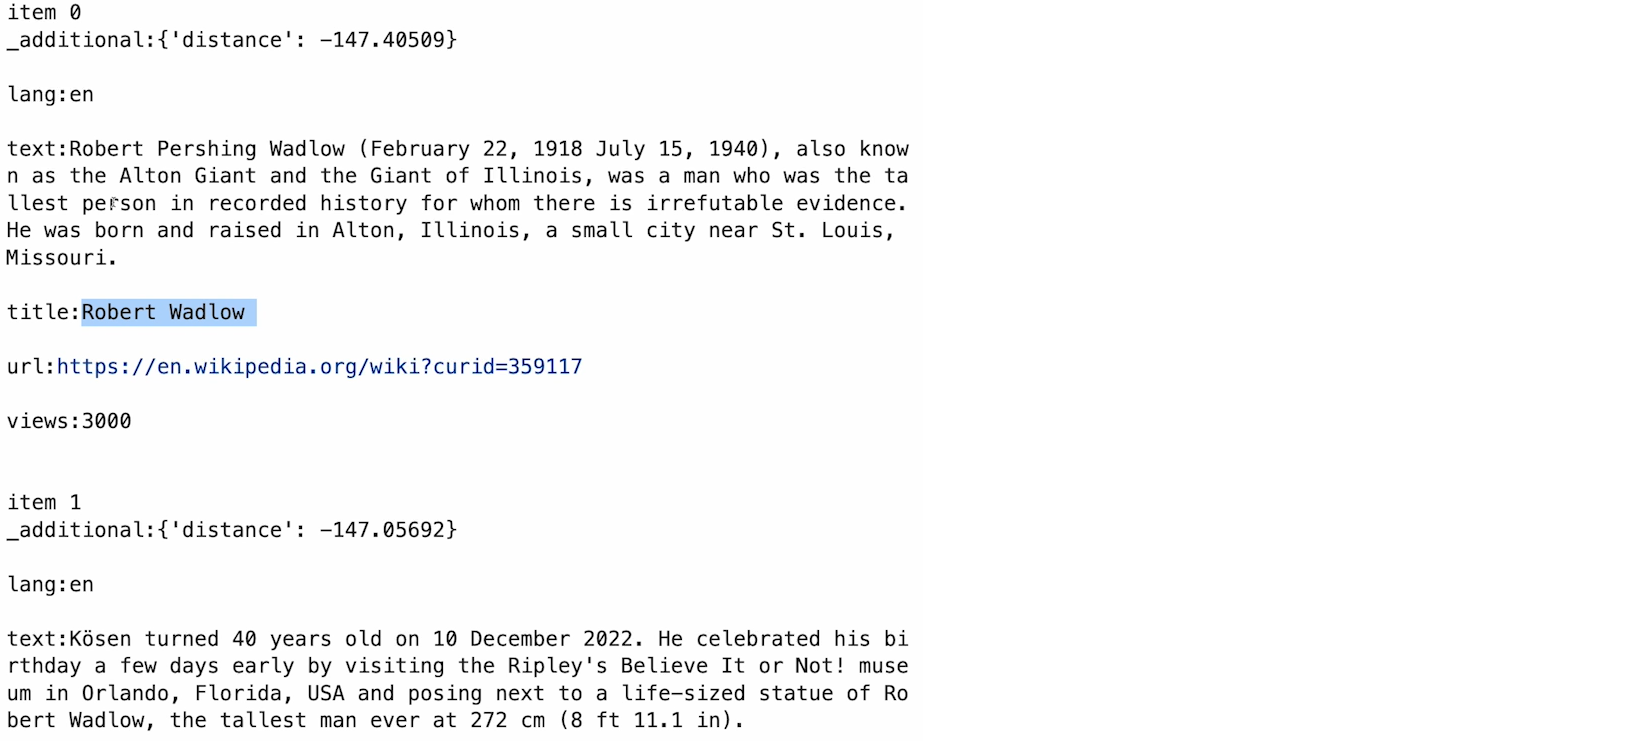

In [ ]:
query = "film about a time travel paradox"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

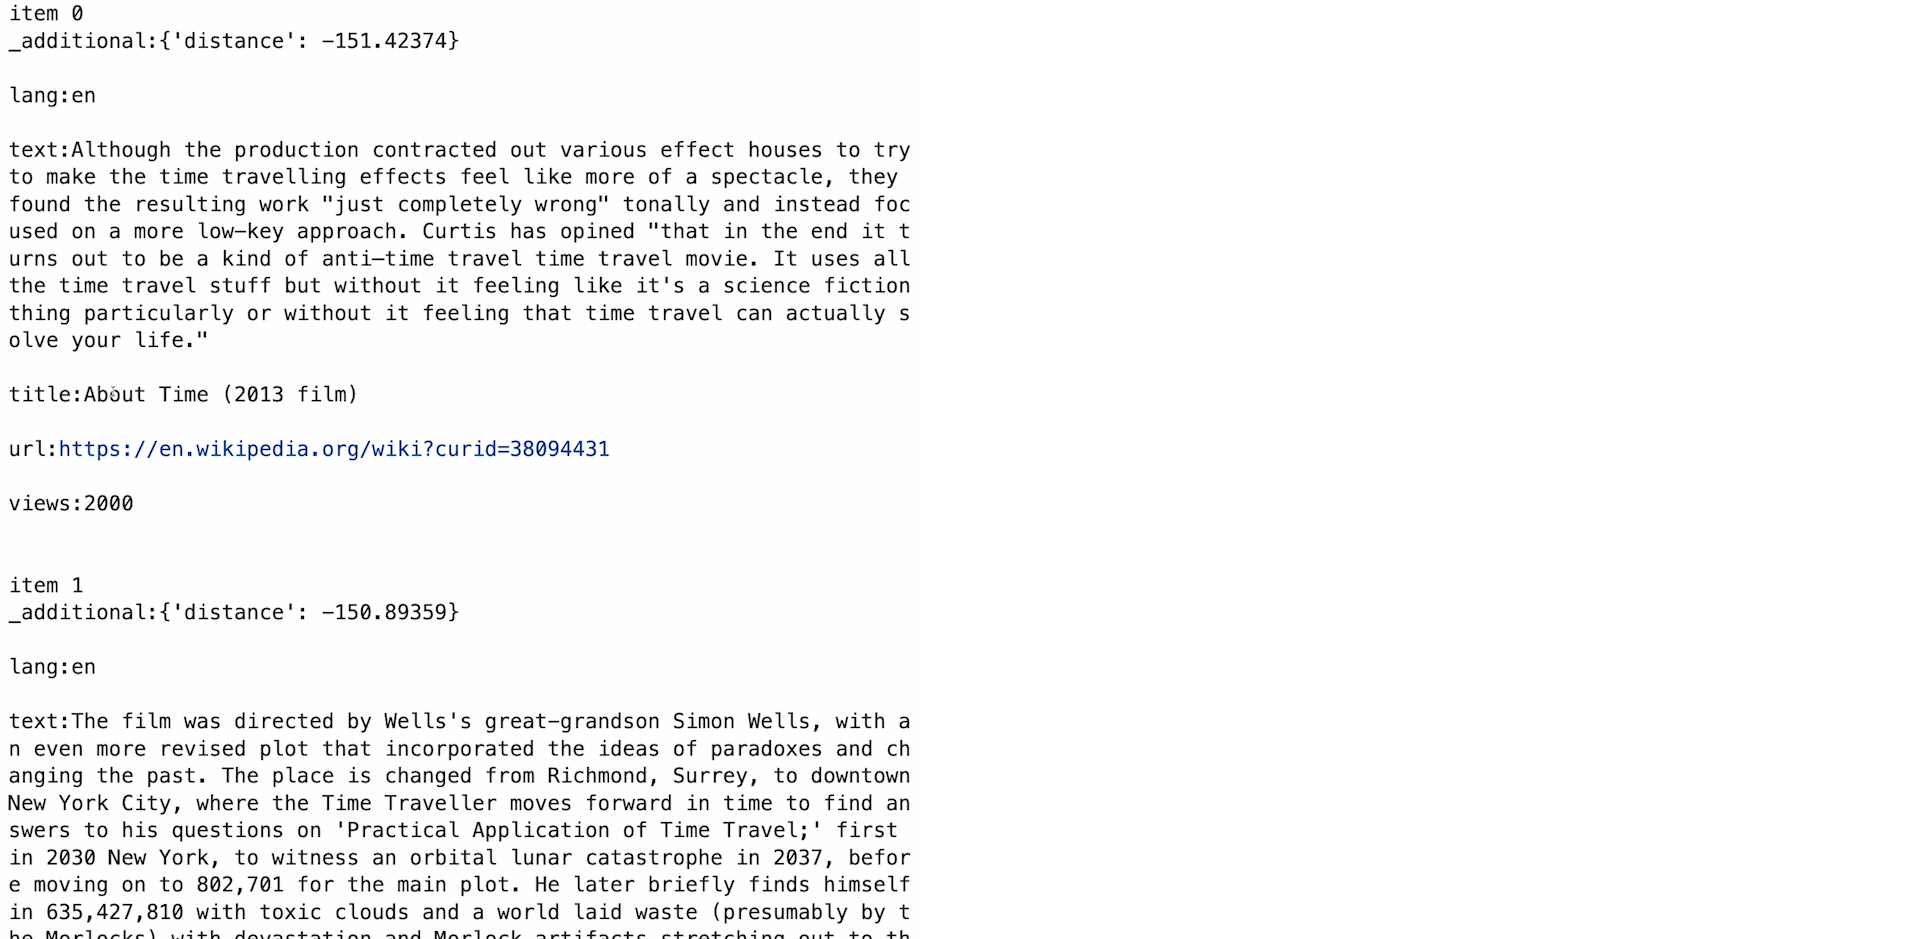

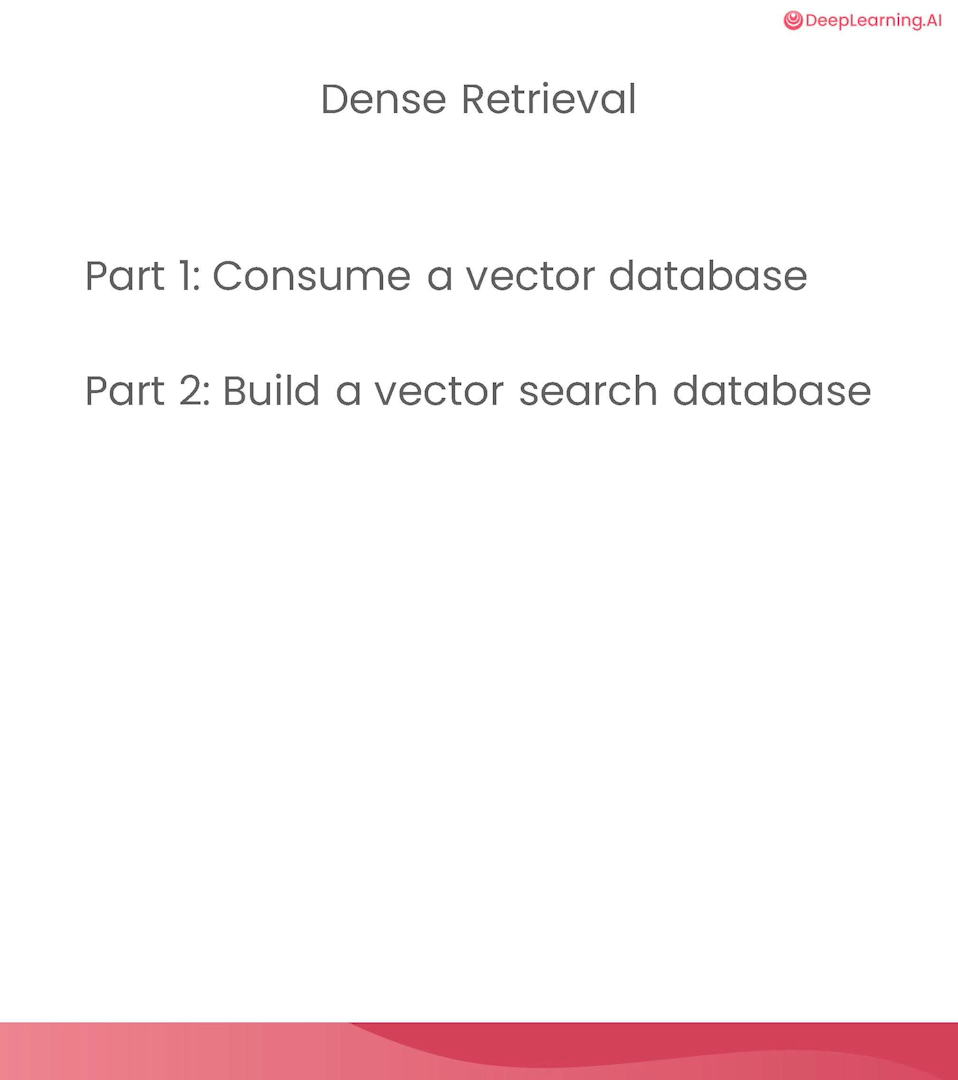

## Part 2: Building Semantic Search from Scratch

### Get the text archive:

The main one here is this library called Annoy, which is a nearest neighbor library. It's kind of similar to Weaviate, but it's a little simpler. 

In [ ]:
from annoy import AnnoyIndex
import numpy as np
import pandas as pd
import re

In [ ]:
text = """
Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan.
It stars Matthew McConaughey, Anne Hathaway, Jessica Chastain, Bill Irwin, Ellen Burstyn, Matt Damon, and Michael Caine.
Set in a dystopian future where humanity is struggling to survive, the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for mankind.

Brothers Christopher and Jonathan Nolan wrote the screenplay, which had its origins in a script Jonathan developed in 2007.
Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar.
Cinematographer Hoyte van Hoytema shot it on 35 mm movie film in the Panavision anamorphic format and IMAX 70 mm.
Principal photography began in late 2013 and took place in Alberta, Iceland, and Los Angeles.
Interstellar uses extensive practical and miniature effects and the company Double Negative created additional digital effects.

Interstellar premiered on October 26, 2014, in Los Angeles.
In the United States, it was first released on film stock, expanding to venues using digital projectors.
The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014.
It received acclaim for its performances, direction, screenplay, musical score, visual effects, ambition, themes, and emotional weight.
It has also received praise from many astronomers for its scientific accuracy and portrayal of theoretical astrophysics. Since its premiere, Interstellar gained a cult following,[5] and now is regarded by many sci-fi experts as one of the best science-fiction films of all time.
Interstellar was nominated for five awards at the 87th Academy Awards, winning Best Visual Effects, and received numerous other accolades"""

So, let's copy a bunch of this text and we'll paste it in the notebook.  Now, this is the text we copied over from Wikipedia. We just added it to this variable called text, and it's just copied and pasted. And then, we come into one of the more important questions around semantic search. So, we need to break this text down into chunks. 

### Chunking: 

But how big are these chunks? Do we split it into sentences? Or do we split it into paragraphs? Or what is the best way to chunk it? And this is a question that is commonly asked, And it's really the answer is different for every task. 

A couple of the common ways is to split, let's say, at every dot. So, we know this text is very clean. All the sentences are separated by periods. So, we can split on the period. But in real life, if you're dealing with a lot of noisy text, you might need to process it a little bit beforehand. 
And then, you might also be needing to use libraries that actually split at various sentences in more complicated or advanced ways than just splitting at the period.

In [ ]:
# Split into a list of sentences
texts = text.split('.')

# Clean up to remove empty spaces and new lines
texts = np.array([t.strip(' \n') for t in texts])

In [ ]:
texts

*OUTPUT*
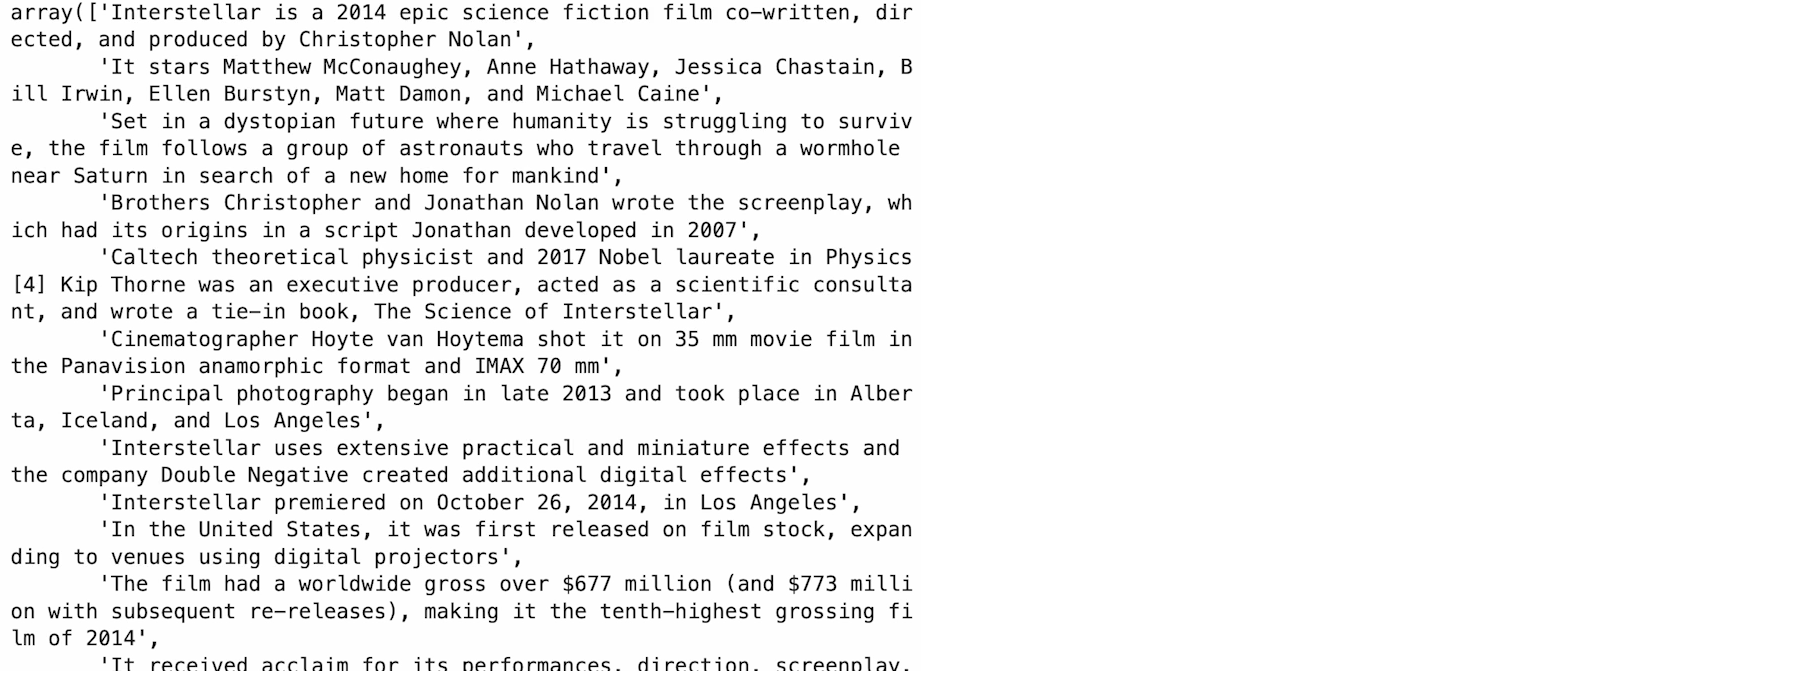

In [ ]:
# Split into a list of paragraphs
texts = text.split('\n\n')

# Clean up to remove empty spaces and new lines
texts = np.array([t.strip(' \n') for t in texts])

In [ ]:
texts

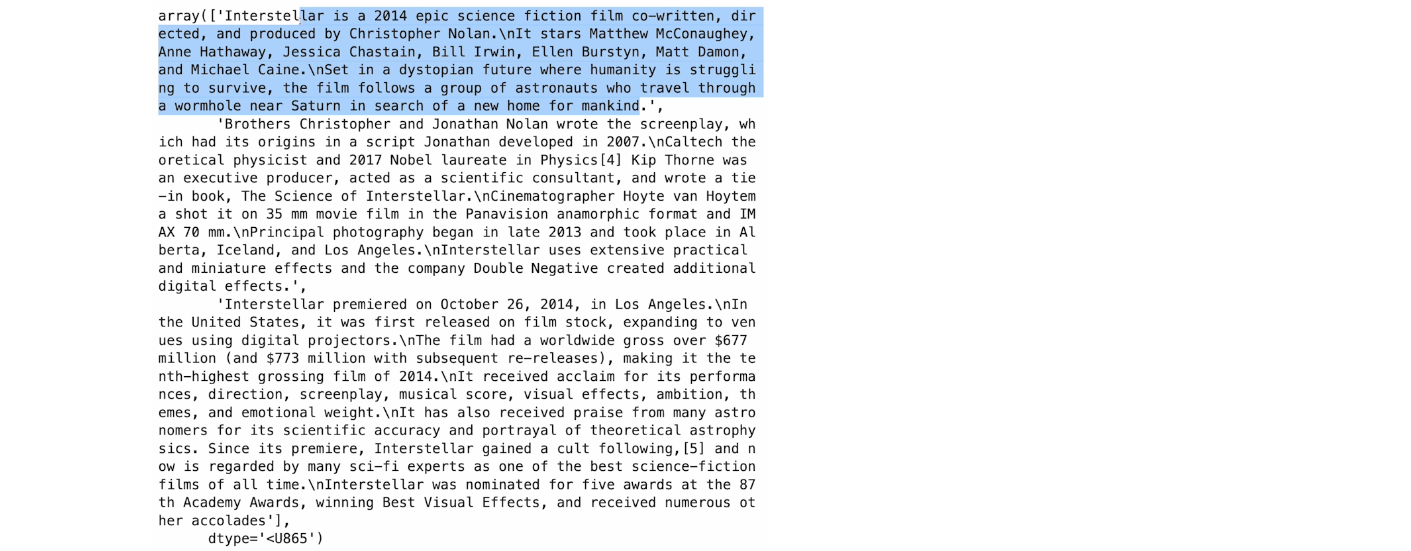

So, what are the texts here now? So, we can see that every sentence is a string inside of this list. And so, this is one way of chunking where every sentence is a list. 

Now, the way that the actual data set, the open source data set that we've we've been working with is. It's actually split on paragraphs, so we're not doing Periods, we're doing paragraphs, and so, each chunk is actually a whole paragraph now which one is right for you that really depends in general you want. Each chunk to maybe contain one idea, But that really depends on the use case that you have but this is one way of doing it. 

In [ ]:
# Split into a list of sentences
texts = text.split('.')

# Clean up to remove empty spaces and new lines
texts = np.array([t.strip(' \n') for t in texts])

In [ ]:
title = 'Interstellar (film)'

texts = np.array([f"{title} {t}" for t in texts])

In [ ]:
texts

*OUTPUT*
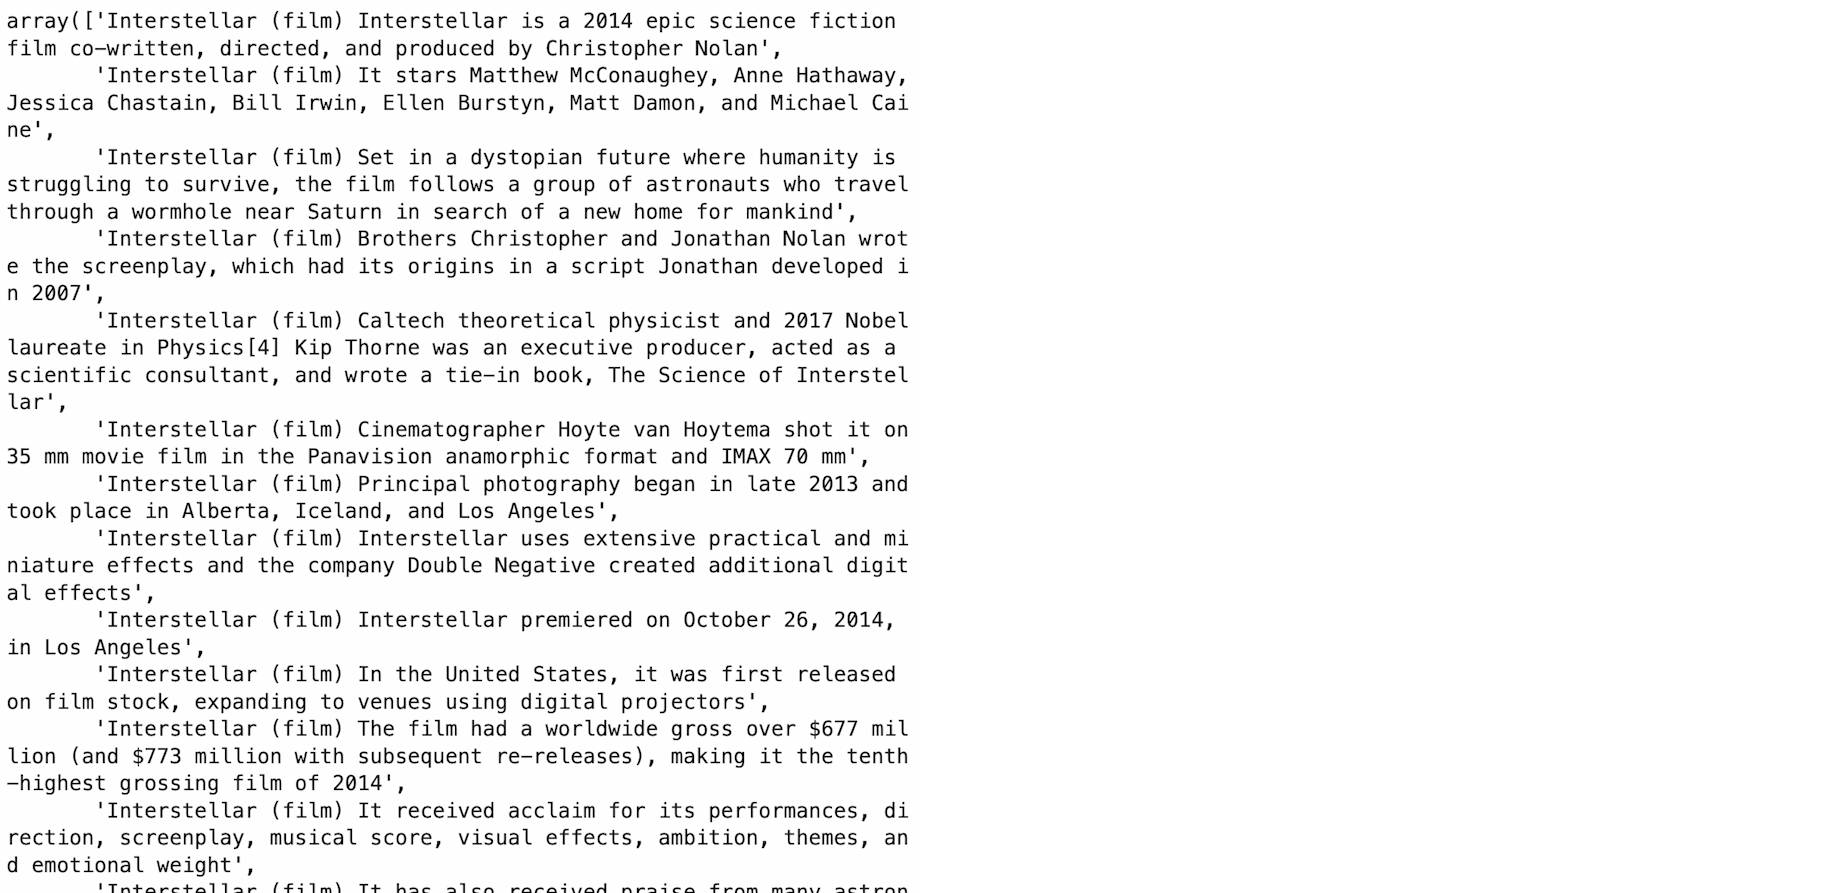

Now, the good thing about Wikipedia is that we have the title, so we can add the title. We can append the title of the page to the sentence. So, it gives it a little bit more context. So, to add that context one thing we can do is copy the title after we copy the title, we can add it to this variable and then just append it to the beginning of each of these chunks and. And then that looks like this. And so, it has received acclaim for its performance. We know that that is now about Interstellar, the film. 

This is a heuristic we've done here for Wikipedia, but then with every database or data set that you have to break or chunk, you need to think about these design choices. 

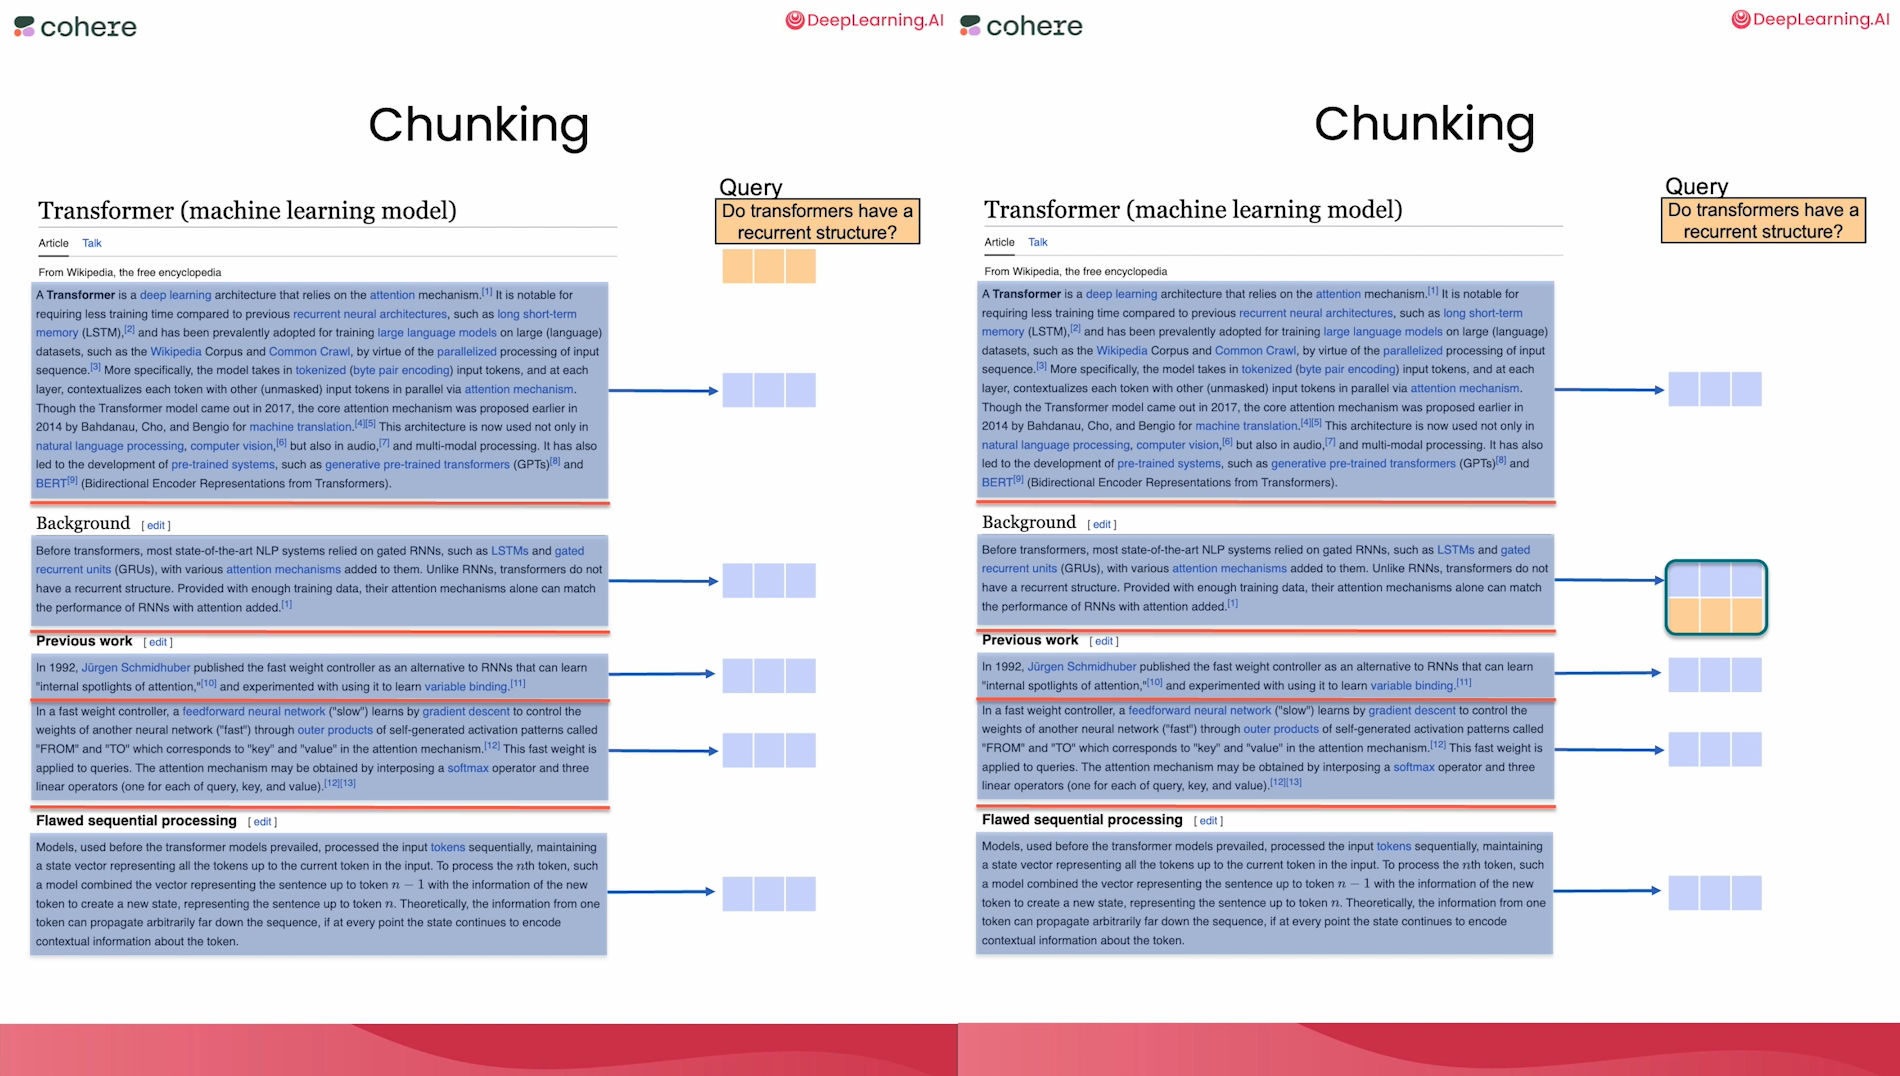

To recap a little bit of what we looked at with chunking, we have a Wikipedia page. 
- We can break it down into paragraphs or into sentences and 
- then we embed each one of these. 

We'll go through the code to do that next. So, each one of these has its own embeddings vector, and then, once we have our query, we embed that query, and then the search is just finding the nearest neighbor, or the nearest article to that query in the embedding space. 
And in this case, if we ask do transformers have a recurrent structure, this article is the one that outlines that and contains the answer for that query. 

### Get the embeddings:

In [ ]:
response = co.embed(
    texts=texts.tolist()
).embeddings
# this response contains the vectors representing these texts that we had in the past. 

In [ ]:
embeds = np.array(response)
embeds.shape

*OUTPUT*
```
(15, 4096)
```

We have the 15 sentences and then each one is represented by a vector of 4,000 numbers. That's the vector that captures the meaning of each of these sentences. 

### Create the search index:

Now, that we have these embeddings, we can throw them at a search library, and start to be able to search them.

In [ ]:
search_index = AnnoyIndex(embeds.shape[1], 'angular')
# Add all the vectors to the search index
for i in range(len(embeds)):
    search_index.add_item(i, embeds[i])

search_index.build(10) # 10 trees
search_index.save('test.ann')

*OUTPUT*
```
True
```

To do that, this is the code for Annoy. We define an index, and then, we iterate over the embeddings that we have, and we insert them into the search index. And then, we have it build them, and then, save the index to file, to disk. So, this is what test.ann, and ann stands for Annoy, but it also stands for approximate nearest neighbor.  With that, we have our vector search index ready, and we can send queries to it, and it will be able to return to us the nearest results from the 15 documents that it has. 

In [ ]:
pd.set_option('display.max_colwidth', None)

def search(query):

  # Get the query's embedding
  query_embed = co.embed(texts=[query]).embeddings

  # Retrieve the nearest neighbors
  similar_item_ids = search_index.get_nns_by_vector(query_embed[0],
                                                    3,
                                                  include_distances=True)
  # Format the results
  results = pd.DataFrame(data={'texts': texts[similar_item_ids[0]],
                              'distance': similar_item_ids[1]})

  print(texts[similar_item_ids[0]])
    
  return results

Let's now define the basic search function and here's what it does. We'll send it a query. It will embed that query, so it sends it to the language model and gets back a embedding for the query. That embedding is then sent to the vector search index, and then, we get the top three results. So, the nearest three neighbors to this query. And then, here we just format them and print them. 

In [ ]:
query = "How much did the film make?"
search(query)

*OUTPUT*
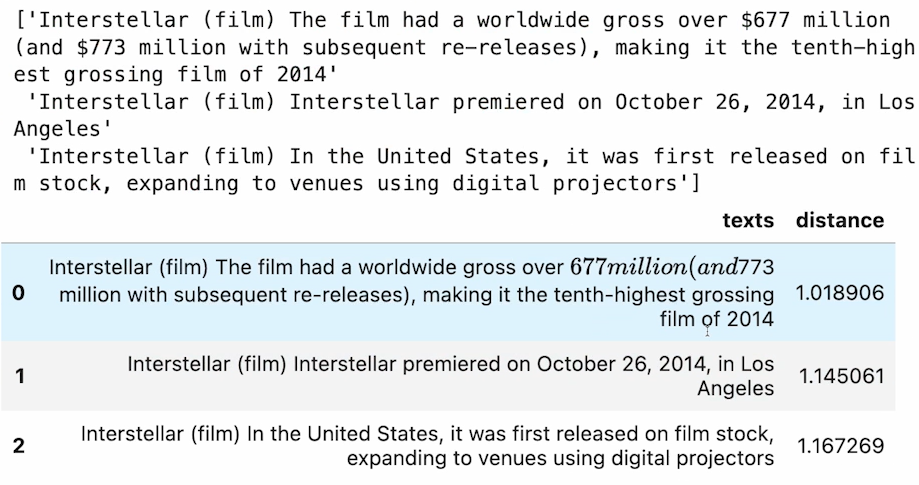

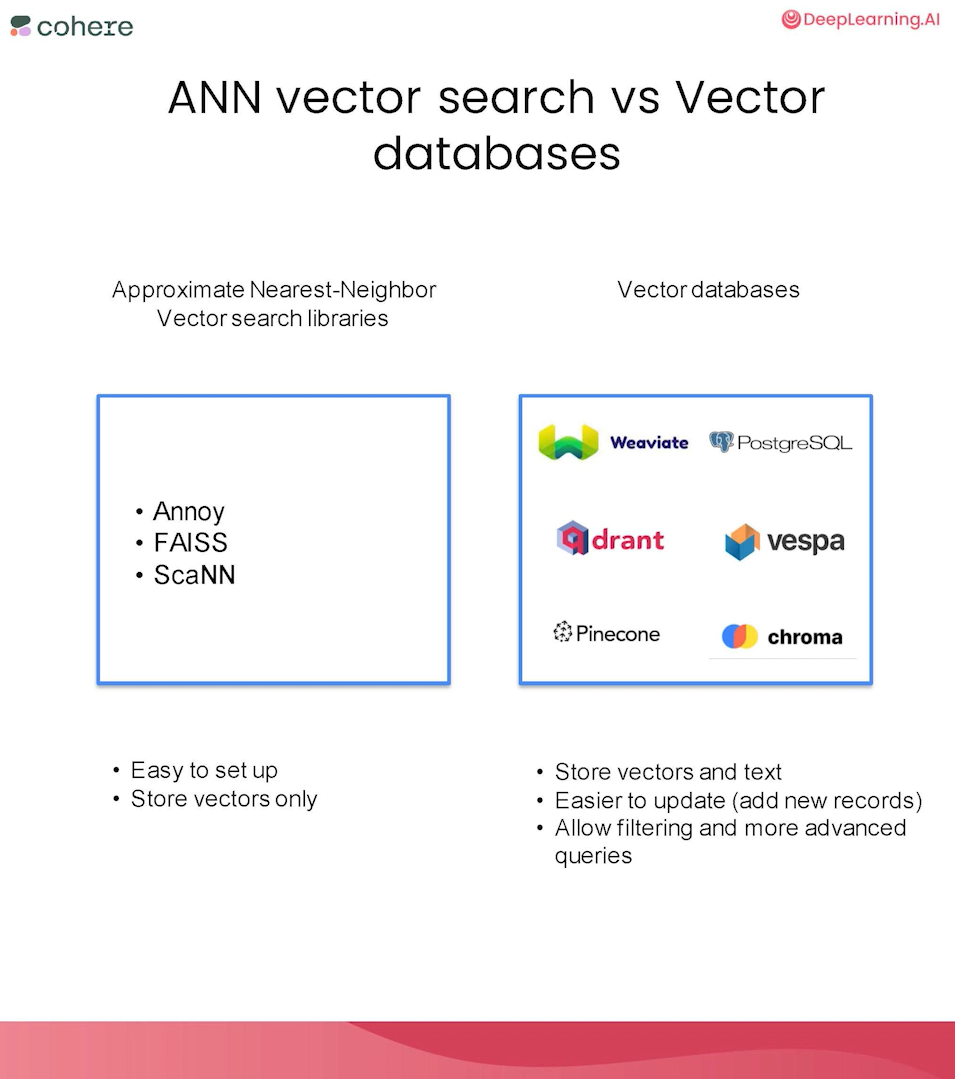

So now, that we've seen how to do dense retrieval, let's talk about vector search using a tool like Annoy that we just saw, which is **Approximate Nearest Neighbor**, and talk about how it compares to this other type of vector search tool called a **vector database**. 

**Dense retrieval really works by finding the nearest neighbors to a search query.**

Now, to make it optimized for speed, we actually search for approximate nearest neighbors. So, finding the exact nearest neighbor is taxing in computation, but we have a lot of really highly optimized algorithms that can get you the approximate nearest neighbor, and that's why they're called ANN or approximate nearest neighbors.

We talked about the Annoy library, but there are a bunch of other ones that are also open source. So, Annoy is from Spotify, FICE is another popular one from Facebook, and Scan from Google are all choices for approximate nearest neighbor vector search libraries.  

On the other hand, the vector databases, there's a lot more variety there and options. So, Weaviate is one of them. There are a couple of other ones that are also online services like Pinecone and a couple more open-source ones. Some of the common choices include Quadrant, Vespa, Chroma, but if you are familiar with databases like PostgresQL, there are extensions for Postgres that do vector search. 

Now, a common question is to wonder what is **the difference between these two**.

So, the approximate nearest neighbor vector search library is usually simpler to set up. So, you saw how Annoy setting it up and installing it is maybe a little easier than the other choices. These vector search libraries also tend to only store the vectors, so they don't store the text. With the Weaviate example, you saw that we gave it a search query. It returned to us the text, so it manages that. And it stores the text, and it is able to retrieve the text that we want. So, it does a little bit more. It's a little bit more feature-rich. 

Another major difference between these libraries and the vector databases is that the databases are easier to update. So, if you want to add new records or modify records, if you're using a library you need to rebuild your index, while if you're using a database, the database handles that for you. 

Vector databases also allow us to filter and do more advanced queries, kind of like what we saw by filtering by the language. These are all useful things that vector databases allow us to do. 

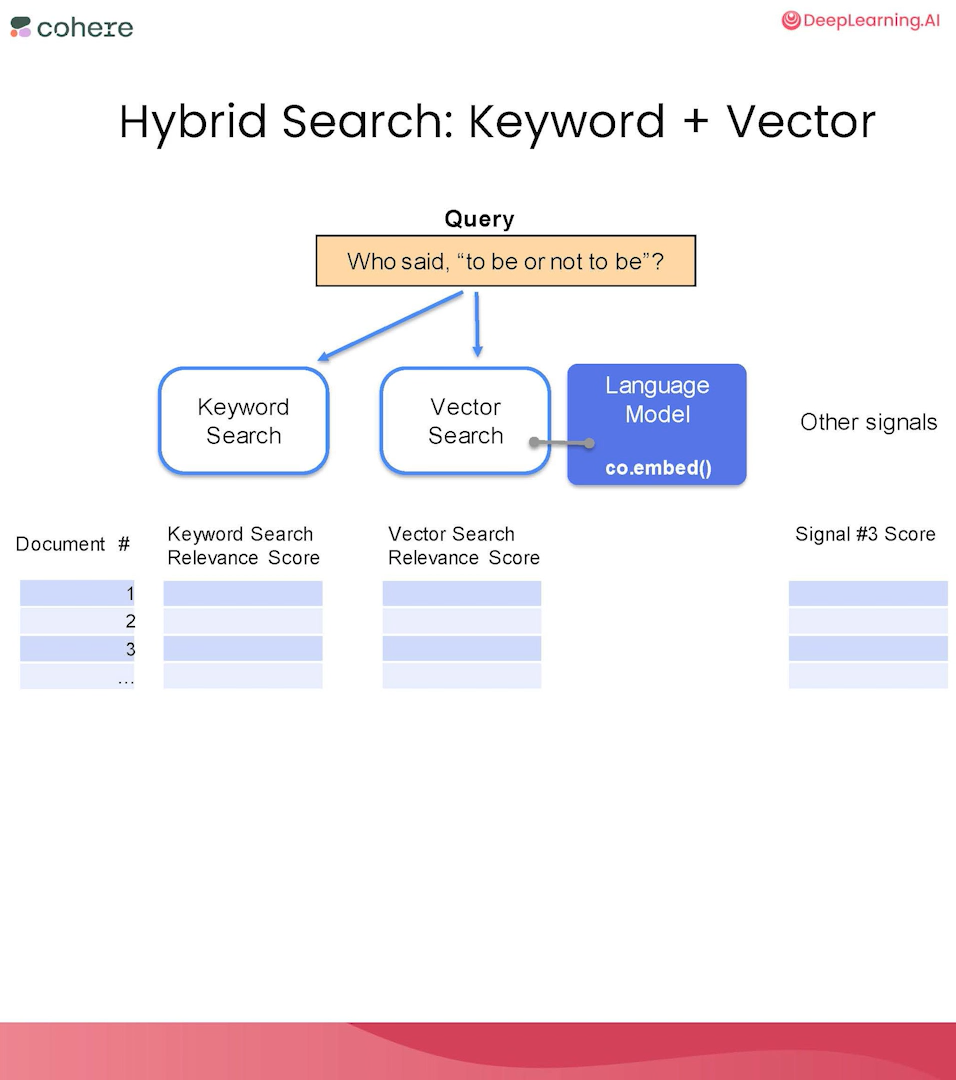

Now, in the real world you don't need to really replace keyword search completely with vector search. They complement each other. You can use them both together in the same pipeline as hybrid search. What that entails is that when you get a query you do keyword search and vector search on it in the same time and you can see how a language model is going to power the vector search component. Both these search components would then give a score, assign a score to each document in the text archive and then we can aggregate these scores and present the best results. 



Do you see this other signals on the right? This is where you can inject other signals into the search results. Google, for example, has its famous PageRank algorithm that assigns an authority score to various web pages and websites based on how many other pages link to them. 
So, you can treat that as an additional signal. Search engines have tens, hundreds, sometimes even thousands of signals that feed into the decision of how they order the search results. So, this is just how you can encompass text relevance with other signals by this aggregation step. In the next lesson, you'll see how re-ranking fits in after the search step and how it can vastly improve this ranking and the relevance of the query to the search results. 


If you want to learn more about the history of dense retrieval in the last few years, this is a really good resource. It's a book and a paper called. Pre-trained Transformers for Text Ranking BERT and Beyond. I highly recommend looking into it if you are interested in the development of these models over the last few years. 
Now, that we've seen how dense retrieval works, which is one of the two main ways of doing semantic search with language models? Let's go to the next lesson where we will learn about the second type, which is called re-ranking.

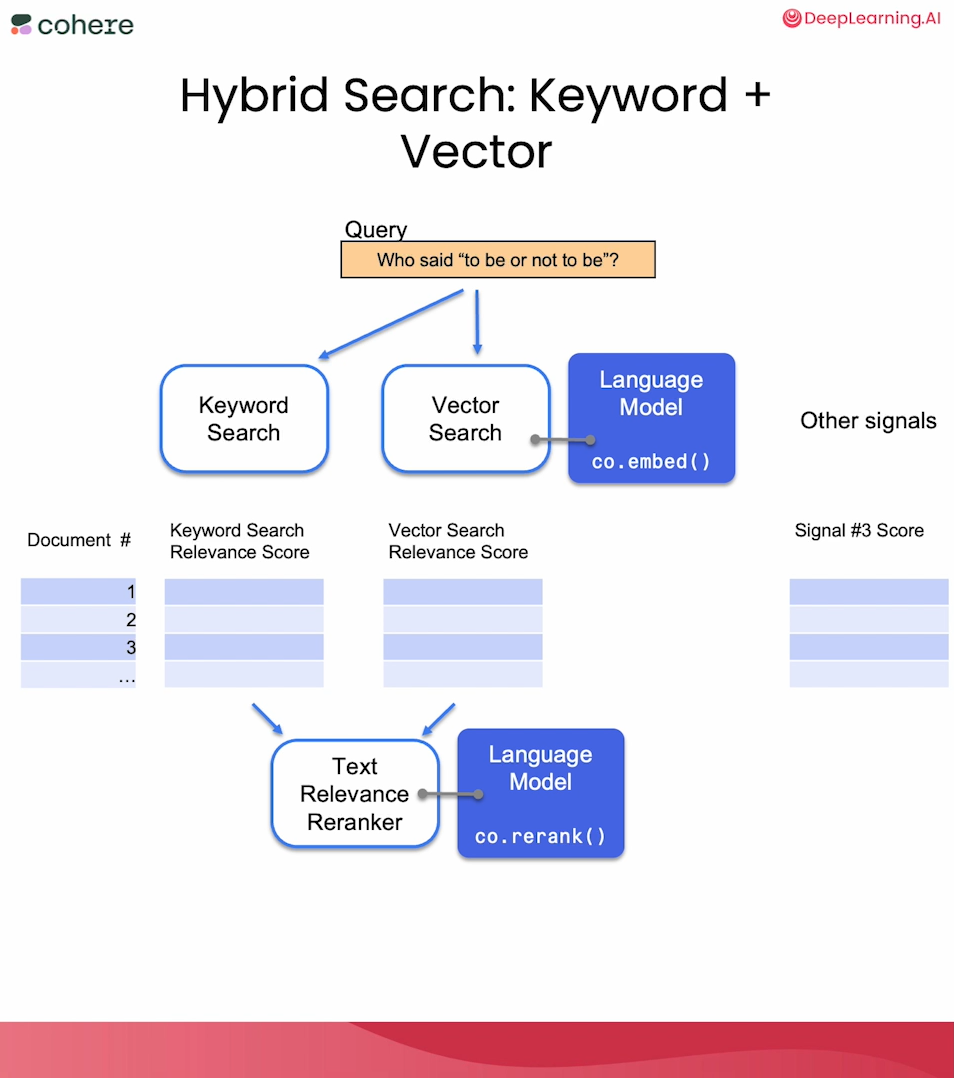